In [1]:
import pandas as pd

In [2]:
#leemos los csv
data2017 = pd.read_csv('DatosMunicipalesSiniestralidad_2017.csv', encoding="latin-1", delimiter=';')
data2018 = pd.read_csv('DatosMunicipalesSiniestralidad_2018.csv', encoding="latin-1", delimiter=';')
data2019 = pd.read_csv('DatosMunicipalesSiniestralidad_2019.csv', encoding="latin-1", delimiter=';')
data2020 = pd.read_csv('DatosMunicipalesSiniestralidad_2020.csv', encoding="latin-1", delimiter=';')
data2021 = pd.read_csv('DatosMunicipalesSiniestralidad_2021.csv', encoding="latin-1", delimiter=';')
data2022 = pd.read_csv('DatosMunicipalesSiniestralidad_2022.csv', encoding="latin-1", delimiter=';')


In [3]:
import pandas as pd

def procesar_datos_geograficos(df, año):
    # Añadir la columna de año
    df["Año"] = año

    # Asegurar que Latitud y Longitud sean cadenas para poder reemplazar comas por puntos
    df["Latitud"] = df["Latitud"].astype(str).str.replace(",", ".")
    df["Longitud"] = df["Longitud"].astype(str).str.replace(",", ".")

    # Convertir las cadenas modificadas a valores flotantes
    df["Latitud"] = df["Latitud"].astype(float)
    df["Longitud"] = df["Longitud"].astype(float)

    # Eliminar filas donde la latitud o la longitud sean NaN
    df.dropna(subset=["Latitud", "Longitud"], inplace=True)
    if 'N Accidentes con Victimas' in df.columns:
        df.dropna(subset=["N Accidentes con Victimas"], inplace=True)
    
    # Definir los límites de latitud y longitud para incluir toda España
    lat_min, lat_max = 27.0, 44.0  # Extender el máximo hacia el norte para incluir todo
    lon_min, lon_max = -18.0, 5.0  # Ajustar si es necesario para capturar todo el este

    # Filtrar el DataFrame por latitud y longitud dentro de estos nuevos límites
    df_filtrado = df[(df["Latitud"] >= lat_min) & (df["Latitud"] <= lat_max) &
                    (df["Longitud"] >= lon_min) & (df["Longitud"] <= lon_max)]

    

    return df_filtrado


In [4]:
df2019 = procesar_datos_geograficos(data2019, 2019)
df2020 = procesar_datos_geograficos(data2020, 2020)
df2018 = procesar_datos_geograficos(data2018, 2018)
df2021 = procesar_datos_geograficos(data2021, 2021)
df2022 = procesar_datos_geograficos(data2022, 2022)
df2017 = procesar_datos_geograficos(data2017, 2017)



In [5]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import folium
import os

# Asumiendo que las variables df2017, df2018, etc., están definidas previamente y disponibles

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Mapa de Accidentes"),
    html.Label("Selecciona un año:"),
    dcc.Dropdown(
        id='year-dropdown',
        options=[
            {'label': '2017', 'value': '2017'},
            {'label': '2018', 'value': '2018'},
            {'label': '2019', 'value': '2019'},
            {'label': '2020', 'value': '2020'},
            {'label': '2021', 'value': '2021'},
            {'label': '2022', 'value': '2022'}
        ],
        value='2017'  # Valor inicial
    ),
    html.Div(id='map-container')
])

@app.callback(
    Output('map-container', 'children'),
    [Input('year-dropdown', 'value')]
)
def update_map(year):
    df = globals().get(f'df{year}')
    if df is None:
        return "No hay datos disponibles para este año."
    
    # Crea el mapa con folium
    mapa = folium.Map(location=[40.4637, -3.7492], zoom_start=6)

    # Añadir marcadores para cada punto de datos
    for index, row in df.iterrows():
        lat = float(row['Latitud'])  # Conversión explícita a float
        lon = float(row['Longitud'])  # Conversión explícita a float
        
        if 'N Accidentes con Victimas' in df.columns:
            num_accidents = float(row['N Accidentes con Victimas'])
        else:
            num_accidents = 0  # Set a default value if the column doesn't exist

        # Añadir un marcador de círculo con un radio proporcional al número de accidentes
        # Aumenta el factor de escala para hacer las burbujas más visibles
        folium.CircleMarker(
            location=[lat, lon],
            radius=max(5, num_accidents / 5),  # Ajuste del factor de escala; garantiza un mínimo de radio para visibilidad
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=f"Accidentes: {num_accidents}"  # Opcional: añade un popup con info
        ).add_to(mapa)
    
    # Guarda el mapa en un archivo HTML
    map_path = 'temp_map.html'
    mapa.save(map_path)

    # Retorna un Iframe con el contenido del mapa
    map_html = open(map_path, 'r', encoding='utf-8').read()
    os.remove(map_path)  # Opcional: elimina el archivo después de leerlo
    return html.Iframe(srcDoc=map_html, width='100%', height='600')

if __name__ == '__main__':
    app.run_server(debug=True)


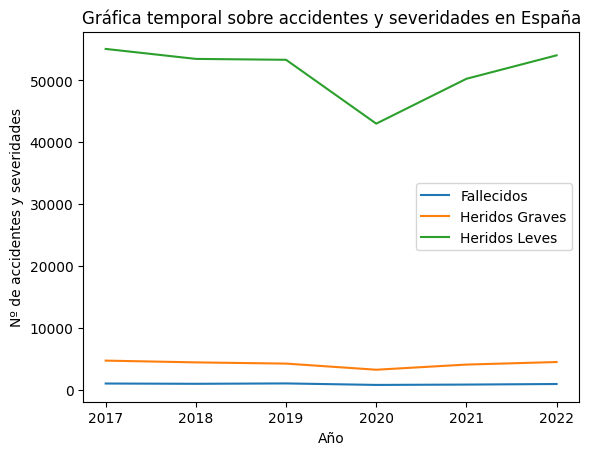

In [6]:
import matplotlib.pyplot as plt

# Create a list of years
years = [2017, 2018, 2019, 2020, 2021, 2022]

# Create empty lists to store the number of accidents and severities for each year
num_accidents = []
fallecidos_total = []
heridos_graves_total = []
heridos_leves_total = []

# Iterate over the years and retrieve the corresponding dataframes
for year in years:
    df = globals().get(f'df{year}')
    if df is not None:
        num_accidents.append(len(df))
        # Filter columns for each severity type
        cols_fallecidos = df.columns[df.columns.str.contains('Fallecidos')]
        cols_heridos_graves = df.columns[df.columns.str.contains('Heridos Graves')]
        cols_heridos_leves = df.columns[df.columns.str.contains('Heridos Leves')]
        # Sum values for each severity type
        fallecidos_total.append(df[cols_fallecidos].sum().sum()) # Sum across columns and then across rows
        heridos_graves_total.append(df[cols_heridos_graves].sum().sum())
        heridos_leves_total.append(df[cols_heridos_leves].sum().sum())



# Plot the severities over time
plt.plot(years, fallecidos_total, label='Fallecidos')
plt.plot(years, heridos_graves_total, label='Heridos Graves')
plt.plot(years, heridos_leves_total, label='Heridos Leves')

# Set the labels and title
plt.xlabel('Año')
plt.ylabel('Nº de accidentes y severidades')
plt.title('Gráfica temporal sobre accidentes y severidades en España')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [9]:
# Este paso asume que ya has combinado tus DataFrames en df_combined
# Aquí hay un ejemplo de cómo podrías hacerlo si no lo has hecho aún
df_combined = pd.concat([df2017, df2018, df2019, df2020, df2021, df2022])

# Lista de tipos de vehículos
vehicle_types = ['Bicicletas', 'Ciclomotores', 'Motocicletas', 'Turismos', 'Furgonetas', 'Camiones', 'Autobus', 'Otros', 'Peatones']

# Inicializa un diccionario para almacenar los resultados
accident_counts = {'Tipo de Vehículo': [], 'Fallecidos': [], 'Heridos Graves': [], 'Heridos Leves': []}

# Llena el diccionario con los datos sumados
for vehicle in vehicle_types:
    accident_counts['Tipo de Vehículo'].append(vehicle)
    accident_counts['Fallecidos'].append(df_combined.filter(like=f'{vehicle} Fallecidos').sum().sum())
    accident_counts['Heridos Graves'].append(df_combined.filter(like=f'{vehicle} Heridos Graves').sum().sum())
    accident_counts['Heridos Leves'].append(df_combined.filter(like=f'{vehicle} Heridos Leves').sum().sum())

# Crea el DataFrame a partir del diccionario
accident_summary_df = pd.DataFrame(accident_counts)

# Establece 'Tipo de Vehículo' como el índice si lo prefieres
accident_summary_df.set_index('Tipo de Vehículo', inplace=True)


In [10]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import pandas as pd

# Asumiendo que accident_summary_df es tu DataFrame y ya está definido
# Si necesitas reconstruir el DataFrame, asegúrate de ejecutar el bloque de código anterior

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Accidentes por Tipo de Vehículo y Severidad"),
    dcc.Dropdown(
        id='severity-type-dropdown',
        options=[
            {'label': 'Fallecidos', 'value': 'Fallecidos'},
            {'label': 'Heridos Graves', 'value': 'Heridos Graves'},
            {'label': 'Heridos Leves', 'value': 'Heridos Leves'}
        ],
        value='Fallecidos',  # Valor predeterminado
        clearable=False
    ),
    dcc.Graph(id='severity-vehicle-graph')
])

@app.callback(
    Output('severity-vehicle-graph', 'figure'),
    [Input('severity-type-dropdown', 'value')]
)
def update_graph(selected_severity):
    filtered_data = accident_summary_df[selected_severity]
    fig = go.Figure(data=[
        go.Bar(
            x=accident_summary_df.index, 
            y=filtered_data,
            text=filtered_data,
            textposition='auto'
        )
    ])
    fig.update_layout(
        title=f'Distribución de {selected_severity} por Tipo de Vehículo',
        xaxis_title="Tipo de Vehículo",
        yaxis_title="Cantidad",
        hovermode="closest"
    )
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [19]:
import plotly.express as px

# Asumiendo que tienes un DataFrame df_accidents con las columnas 'Latitud', 'Longitud' y 'Severidad'
# donde 'Severidad' podría ser 'Fallecidos', 'Heridos Graves' o 'Heridos Leves'.
# Si no tienes este DataFrame, necesitarás transformar df_combined para crearlo.

# Ejemplo de cómo podría verse df_accidents (debes crear este DataFrame basado en tus datos):
# df_accidents = pd.DataFrame({
#     'Latitud': [40.416775, 40.416775, 40.403879],
#     'Longitud': [-3.703790, -3.703790, -3.692412],
#     'Severidad': ['Fallecidos', 'Heridos Graves', 'Heridos Leves']
# })

# Crear el mapa utilizando Plotly Express
fig = px.scatter_geo(accident_summary_df,
                     lat='Latitud',
                     lon='Longitud',
                     color='Severidad',  # Diferencia los puntos por severidad
                     hover_name='Severidad',  # Muestra la severidad al pasar el ratón por encima
                     projection='natural earth',  # Elige el tipo de proyección del mapa
                     title='Distribución Geográfica de la Severidad de los Accidentes')

fig.show()


ValueError: Value of 'hover_name' is not the name of a column in 'data_frame'. Expected one of ['Fallecidos', 'Heridos Graves', 'Heridos Leves', 'Tipo de Vehículo'] but received: Severidad

In [17]:
df2017.columns

Index(['ï»¿CÃ³digo INE', 'Municipio', 'Provincia', 'Comunidad AutÃ³noma',
       'Bicicletas Fallecidos', 'Bicicletas Heridos Graves',
       'Bicicletas Heridos Leves', 'Ciclomotores Fallecidos',
       'Ciclomotores Heridos Graves', 'Ciclomotores Heridos Leves',
       'Motocicletas Fallecidos', 'Motocicletas Heridos Graves',
       'Motocicletas Heridos Leves', 'Turismos Fallecidos',
       'Turismos Heridos Graves', 'Turismos Heridos Leves',
       'Furgonetas Fallecidos', 'Furgonetas Heridos Graves',
       'Furgonetas Heridos Leves', 'Camiones Fallecidos',
       'Camiones Heridos Graves', 'Camiones Heridos Leves',
       'Autobus Fallecidos', 'Autobus Heridos Graves', 'Autobus Heridos Leves',
       'Otros Fallecidos', 'Otros Heridos Graves', 'Otros Heridos Leves',
       'Peatones Fallecidos', 'Peatones Heridos Graves',
       'Peatones Heridos Leves', 'N Accidentes con Victimas', 'Fallecidos',
       'Heridos Hospitalizados', 'Heridos no Hospitalizados', 'Unnamed: 35',
       